#### NHANES Cardiovascular Disease Analysis and predictive modelling

In [1]:
import glob 
import os
import numpy as np
import pandas as pd
import sys

### Preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from numpy import isnan
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import shuffle

### Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pylab import *
import missingno as msno

### Sklearn
from sklearn import metrics,decomposition,svm
from sklearn.neighbors import kneighbors_graph 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error,balanced_accuracy_score,roc_auc_score,precision_score,recall_score,multilabel_confusion_matrix,confusion_matrix,auc,classification_report,accuracy_score,f1_score,roc_curve,precision_recall_curve,average_precision_score 
from scikitplot.metrics import plot_roc_curve
from scipy.sparse.linalg import expm
from sklearn.impute import KNNImputer

### Keras/Tensorflow
from keras.models import Sequential, Model, Input
from keras.optimizers import Adam,SGD
from keras.layers import Dense, Dropout,Activation

### Warning
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: Future

#### Functions for preprocessing inintial dataset

In [2]:
# Drop duplicate columns
def dropCols(dataset):
    colx = [a for a in dataset if a.endswith('_x')]
    coly = [a for a in dataset if a.endswith('_y')]
    dataset.drop(colx,axis=1,inplace=True)
    dataset.drop(coly,axis=1,inplace=True)

def readFolder(path1,path2,labels):    
    dataset=pd.read_sas(glob.glob(NHANES+path1+XPT)[0].format())
    files = glob.glob(NHANES+path1+XPT)
    files2 = glob.glob(NHANES+path2+XPT)
    dataset1=loopFiles(files,dataset,labels[0])
    d2=pd.read_sas(glob.glob(NHANES+path2+XPT)[0].format())
    dataset2=loopFiles(files2,d2,labels[1])
    dataset=pd.concat([dataset1, dataset2],sort=False)
    return dataset 

def loopFiles(files,dataset,labels):
    for file in files:
        temp=pd.read_sas(file)
        dataset=dataset.join(temp.set_index('SEQN'), on='SEQN',how='left',lsuffix='_x')#how='left', lsuffix='_left', rsuffix='_right'
    #print('Nunmber of Files:',len(files))
    questionare = pd.read_sas(NHANES+labels)
    seqn,ques=getPatientLabels(questionare)
    seqn={'SEQN':seqn, 'CVD':ques}
    label = pd.DataFrame(seqn)
    dataset=dataset.join(label.set_index('SEQN'), on='SEQN')
    dropCols(dataset)
    return dataset

#### extract patient labels from questionnare and combine into 1 columns based on OR gate
def getPatientLabels(data):
    ques = data[['MCQ160B','MCQ160C','MCQ160D','MCQ160E','MCQ160F']] #### Heart Disease labels
    ques = ques[ques < 3].replace(2, 0) # Keep only yes or no values
    ques = ques.dropna()
    ques = ques.MCQ160B.astype(int)|ques.MCQ160C.astype(int)|ques.MCQ160E.astype(int)|ques.MCQ160F.astype(int)|ques.MCQ160D.astype(int) # OR gate function
    seqn = data['SEQN']
    seqn=seqn[ques.index]
    return seqn,ques

### Get dataset and split into X and Y
def getXY(data):
    x=data.iloc[:,1:data.shape[1]-1] 
    y=data.iloc[:,data.shape[1]-1:data.shape[1]].astype(int) 
    return x,y

### Combines laboratory, questionnare and examination datasets based on patient ID
def combineDatasets(originalData,newData):
    originalData=originalData.join(newData.set_index('SEQN'), on='SEQN',how='left',lsuffix='_x')#how='left', lsuffix='_left', rsuffix='_right'
    dropCols(originalData)
    return originalData

#### File names        
lab=['2013/Lab','2015/Lab']
quest=['2013/Questionnares','2015/Questionnares']
measurement=['2013/Measurements','2015/Measurements']
labels=['2013/Label/MCQ_H.XPT','2015/Label/MCQ_I.XPT']
NHANES='NHANES/'
XPT='/*.XPT'

#### ML Functions

In [3]:
### Removes sample on the class ratio balance proposed
def defineClassRatio(dataset,n):
    zeroIndices = dataset.index[dataset['CVD']==0]
    dataset.drop(zeroIndices[:n],inplace=True) 
    print('Class Ratio',dataset['CVD'][dataset['CVD']==0].count(),':',dataset['CVD'][dataset['CVD']==1].count())
    return dataset

def printAccLoss(history):
    H = history.history
    fig = plt.figure(figsize = (20, 7))
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label = 'Train')
    plt.plot(history.history['val_accuracy'], label = 'Test')
    plt.grid()
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['loss'], label = 'Train')
    plt.plot(history.history['val_loss'], label = 'Test')
    plt.grid()
    plt.legend()
    
def printConfMatrix(predicted,y_test):
    fig = plt.figure(figsize = (6, 6))
    confM=confusion_matrix(y_test,predicted)
    #c=accuracy_score(predicted,y_test)
    plt.title("Confustion Matrix")
    sns.heatmap(confM,annot=True,fmt="d",cbar=False,cmap='Blues')
    plt.show()
    
### Assign 1 if threshold over 0.5 and 0 if less. Print Score 
def printNetStats():
    predicted = model.predict(X_test)
    predicted[predicted>=0.5] = 1
    predicted[predicted<0.5] = 0
    confusion = confusion_matrix(y_test, predicted)
    score = model.evaluate(X_test, y_test,verbose=1)
    print('Score: ',score)
    print(classification_report(y_test,predicted))
    printAccLoss()

def neuralNetwork(X_train, X_test, y_train, y_test,x,lrate,drop1,drop2):
    network = Sequential()
    network.add(Dense(128,  activation='relu', input_shape=(x.shape[1],))) 
    network.add(Dropout(drop1)) 
    network.add(Dense(64,  activation='relu', )) 
    network.add(Dropout(drop2))
    network.add(Dense(32,  activation='relu', )) 
    network.add(Dense(1,activation='sigmoid'))
    sgd = SGD(lr=lrate)
    network.compile(loss='binary_crossentropy', optimizer=sgd,metrics=['accuracy']) #loss='mse',binary_crossentropy
    history = network.fit(X_train,y_train, epochs=100,validation_data=(X_test, y_test))
    #model.summary()
    return network,history

### Main loop
def setLrate(dataset,lrate,drop1,drop2):
    for i in range(len(n)):
        dataset=defineClassRatio(dataset,n[i]) # for 6:1 class ration
        x,y=getXY(dataset)
        std = StandardScaler()
        x=std.fit_transform(x)
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,stratify=y)
        print(X_train.shape)
        network,history=neuralNetwork(X_train, X_test, y_train, y_test,x,lrate,drop1,drop2)
        predicted = network.predict(X_test)
        predicted[predicted>=0.5] = 1
        predicted[predicted<0.5] = 0
        confusion = confusion_matrix(y_test, predicted)
        score = network.evaluate(X_test, y_test,verbose=1)
        print('Score: ',score)
        print(classification_report(y_test,predicted))
        printConfMatrix(predicted,y_test)
        printAccLoss(history)

#### Import py file for reading names

In [4]:
%run dataNames.py
colNames=featNames

#### Read NHANES 2013-2016 files and combine datasets. Add 'CVD' disease label taken from questionnare dataset. Total of 18,587 samples, 614 features

In [5]:
lab=readFolder(lab[0],lab[1],labels)
quest=readFolder(quest[0],quest[1],labels)
meas=readFolder(measurement[0],measurement[1],labels)
dataset=combineDatasets(lab,quest)
dataset=combineDatasets(dataset,meas)
dataset.drop(datasetToDrop, axis=1,inplace=True)
## Drop labels from dataset
cvd=['MCQ160D','MCQ160F','MCQ160B','MCQ160C','MCQ160E']
dataset.drop(cvd, axis=1,inplace=True) ## Remove heart disease labels from the dataset
dataset.rename(columns=colNames,inplace=True)

dataset.shape

(18587, 614)

In [6]:
dataset.head()

,ID,White-Blood-Cell,Lymphocyte,Monocyte,Segmented-neutrophils,Eosinophils,Basophils,LymphocyteN,MonocyteN,Segmented-neutrophilsN,...,Arm-Circumference,BMIARMC,BMIWAIST,Sagittal-Abdominal-Diameter,BMXSAD3,BMXSAD4,BMDSADCM,Gender,Age,CVD
0,73557.0,4.7,42.2,11.0,42.3,3.4,1.2,2.0,0.5,2.0,...,35.3,NaN,NaN,20.5,NaN,NaN,NaN,1.0,69.0,1.0
1,73558.0,12.6,27.3,7.6,58.4,6.1,0.6,3.4,1.0,7.4,...,34.7,NaN,NaN,24.2,NaN,NaN,NaN,1.0,54.0,0.0
2,73559.0,7.2,13.9,11.5,68.2,5.6,0.9,1.0,0.8,4.9,...,33.5,NaN,NaN,25.8,NaN,NaN,NaN,1.0,72.0,0.0
3,73560.0,7.8,29.6,9.2,59.1,1.7,0.4,2.3,0.7,4.6,...,21.0,NaN,NaN,14.8,NaN,NaN,NaN,1.0,9.0,NaN
4,73561.0,6.6,20.5,6.9,68.7,2.4,1.4,1.4,0.5,4.5,...,25.2,NaN,1.0,NaN,NaN,NaN,1.0,2.0,73.0,0.0


### Data Cleaning

#### Many unwanted features: duplicates, comment codes, collinear, high missing percentage
##### First, remove all features with over 60% of the data missing. We are left with 255 features. Remove patients with no labels recorded.

In [23]:
dataset=dataset[dataset.columns[dataset.isnull().mean() < 0.55]]
dataset=dataset[dataset['CVD'].notna()] ## Select only columns with no NAN Values 
print('shape: ',dataset.shape)
dataset.head()

shape:  (10979, 156)


,ID,White-Blood-Cell,Lymphocyte,Monocyte,Segmented-neutrophils,Eosinophils,Basophils,LymphocyteN,MonocyteN,Segmented-neutrophilsN,...,Weight,Standing-Height-cm,BMI,Upper-Leg-Length,Upper Arm Length (cm),Arm-Circumference,Sagittal-Abdominal-Diameter,Gender,Age,CVD
0,73557.0,4.7,42.2,11.0,42.3,3.4,1.2,2.0,0.5,2.0,...,78.3,171.3,26.7,39.2,40.2,35.3,20.5,1.0,69.0,1.0
1,73558.0,12.6,27.3,7.6,58.4,6.1,0.6,3.4,1.0,7.4,...,89.5,176.8,28.6,40.0,41.5,34.7,24.2,1.0,54.0,0.0
2,73559.0,7.2,13.9,11.5,68.2,5.6,0.9,1.0,0.8,4.9,...,88.9,175.3,28.9,40.0,41.0,33.5,25.8,1.0,72.0,0.0
4,73561.0,6.6,20.5,6.9,68.7,2.4,1.4,1.4,0.5,4.5,...,52.0,162.4,19.7,36.3,37.5,25.2,NaN,2.0,73.0,0.0
5,73562.0,9.4,17.4,6.6,69.2,5.9,0.9,1.6,0.6,6.5,...,105.0,158.7,41.7,34.2,36.2,41.8,29.1,1.0,56.0,1.0


#### To deal with collinear variables, find features with correlation of .95+ and remove if applicable

In [9]:
corr=dataset.corr()
features = dataset.corr().columns.values
for column, row in (corr.abs() > .95 ).iteritems():
    print(column, features[row.values])


ID ['ID']
White-Blood-Cell ['White-Blood-Cell']
Lymphocyte ['Lymphocyte']
Monocyte ['Monocyte']
Segmented-neutrophils ['Segmented-neutrophils']
Eosinophils ['Eosinophils']
Basophils ['Basophils']
LymphocyteN ['LymphocyteN']
MonocyteN ['MonocyteN']
Segmented-neutrophilsN ['Segmented-neutrophilsN']
EosinophilsN ['EosinophilsN']
BasophilsN ['BasophilsN']
Red-Blood-Cell ['Red-Blood-Cell']
Hemoglobin ['Hemoglobin']
Mean-cell-volume ['Mean-cell-volume']
Mean-cell-hemoglobin ['Mean-cell-hemoglobin']
MCHC ['MCHC']
Red-cell-distribution-width ['Red-cell-distribution-width']
Platelet-Count ['Platelet-Count']
Mean-Platelet-Volume ['Mean-Platelet-Volume']
Albumin-Urine ['Albumin-Urine' 'URXUMS']
URXUMS ['Albumin-Urine' 'URXUMS']
URXCRS ['URXCRS']
Alb-Cre-Ratio ['Alb-Cre-Ratio']
Testosterone ['Testosterone']
Estradiol ['Estradiol']
LBXSHBG ['LBXSHBG']
Cotinine ['Cotinine']
Hydroxycotinine ['Hydroxycotinine']
Total-Cholestrol ['Total-Cholestrol' 'LBDTCSI']
LBDTCSI ['Total-Cholestrol' 'LBDTCSI']
Dire

#### Distribution of missing data

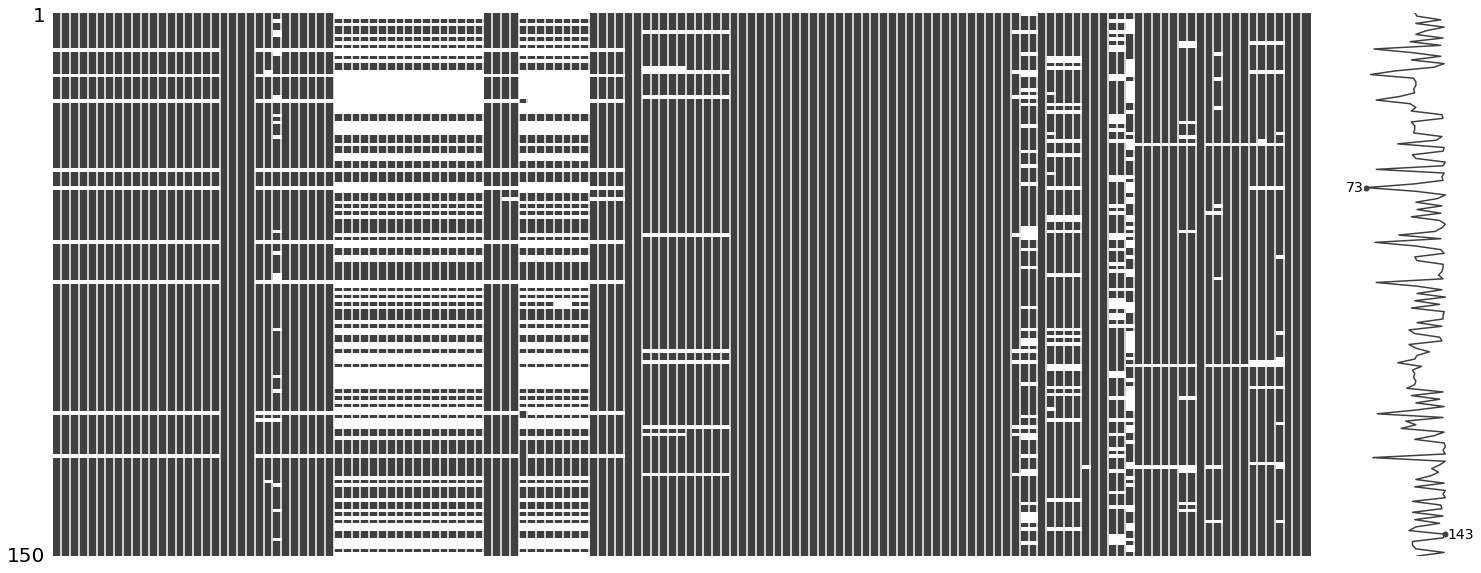

In [11]:
l=dataset.iloc[:,1:]
msno.matrix(l.sample(150),labels=False,) 
plt.xticks(rotation=90)
plt.show()

#### Data Imputation

In [12]:
imputer = KNNImputer(n_neighbors=3)
NHANES = imputer.fit_transform(dataset)
NHANES =pd.DataFrame(NHANES,columns=dataset.columns)
NHANES.head()

,ID,White-Blood-Cell,Lymphocyte,Monocyte,Segmented-neutrophils,Eosinophils,Basophils,LymphocyteN,MonocyteN,Segmented-neutrophilsN,...,Weight,Standing-Height-cm,BMI,Upper-Leg-Length,Upper Arm Length (cm),Arm-Circumference,Sagittal-Abdominal-Diameter,Gender,Age,CVD
0,73557.0,4.7,42.2,11.0,42.3,3.4,1.2,2.0,0.5,2.0,...,78.3,171.3,26.7,39.2,40.2,35.3,20.500000,1.0,69.0,1.0
1,73558.0,12.6,27.3,7.6,58.4,6.1,0.6,3.4,1.0,7.4,...,89.5,176.8,28.6,40.0,41.5,34.7,24.200000,1.0,54.0,0.0
2,73559.0,7.2,13.9,11.5,68.2,5.6,0.9,1.0,0.8,4.9,...,88.9,175.3,28.9,40.0,41.0,33.5,25.800000,1.0,72.0,0.0
3,73561.0,6.6,20.5,6.9,68.7,2.4,1.4,1.4,0.5,4.5,...,52.0,162.4,19.7,36.3,37.5,25.2,29.633333,2.0,73.0,0.0
4,73562.0,9.4,17.4,6.6,69.2,5.9,0.9,1.6,0.6,6.5,...,105.0,158.7,41.7,34.2,36.2,41.8,29.100000,1.0,56.0,1.0


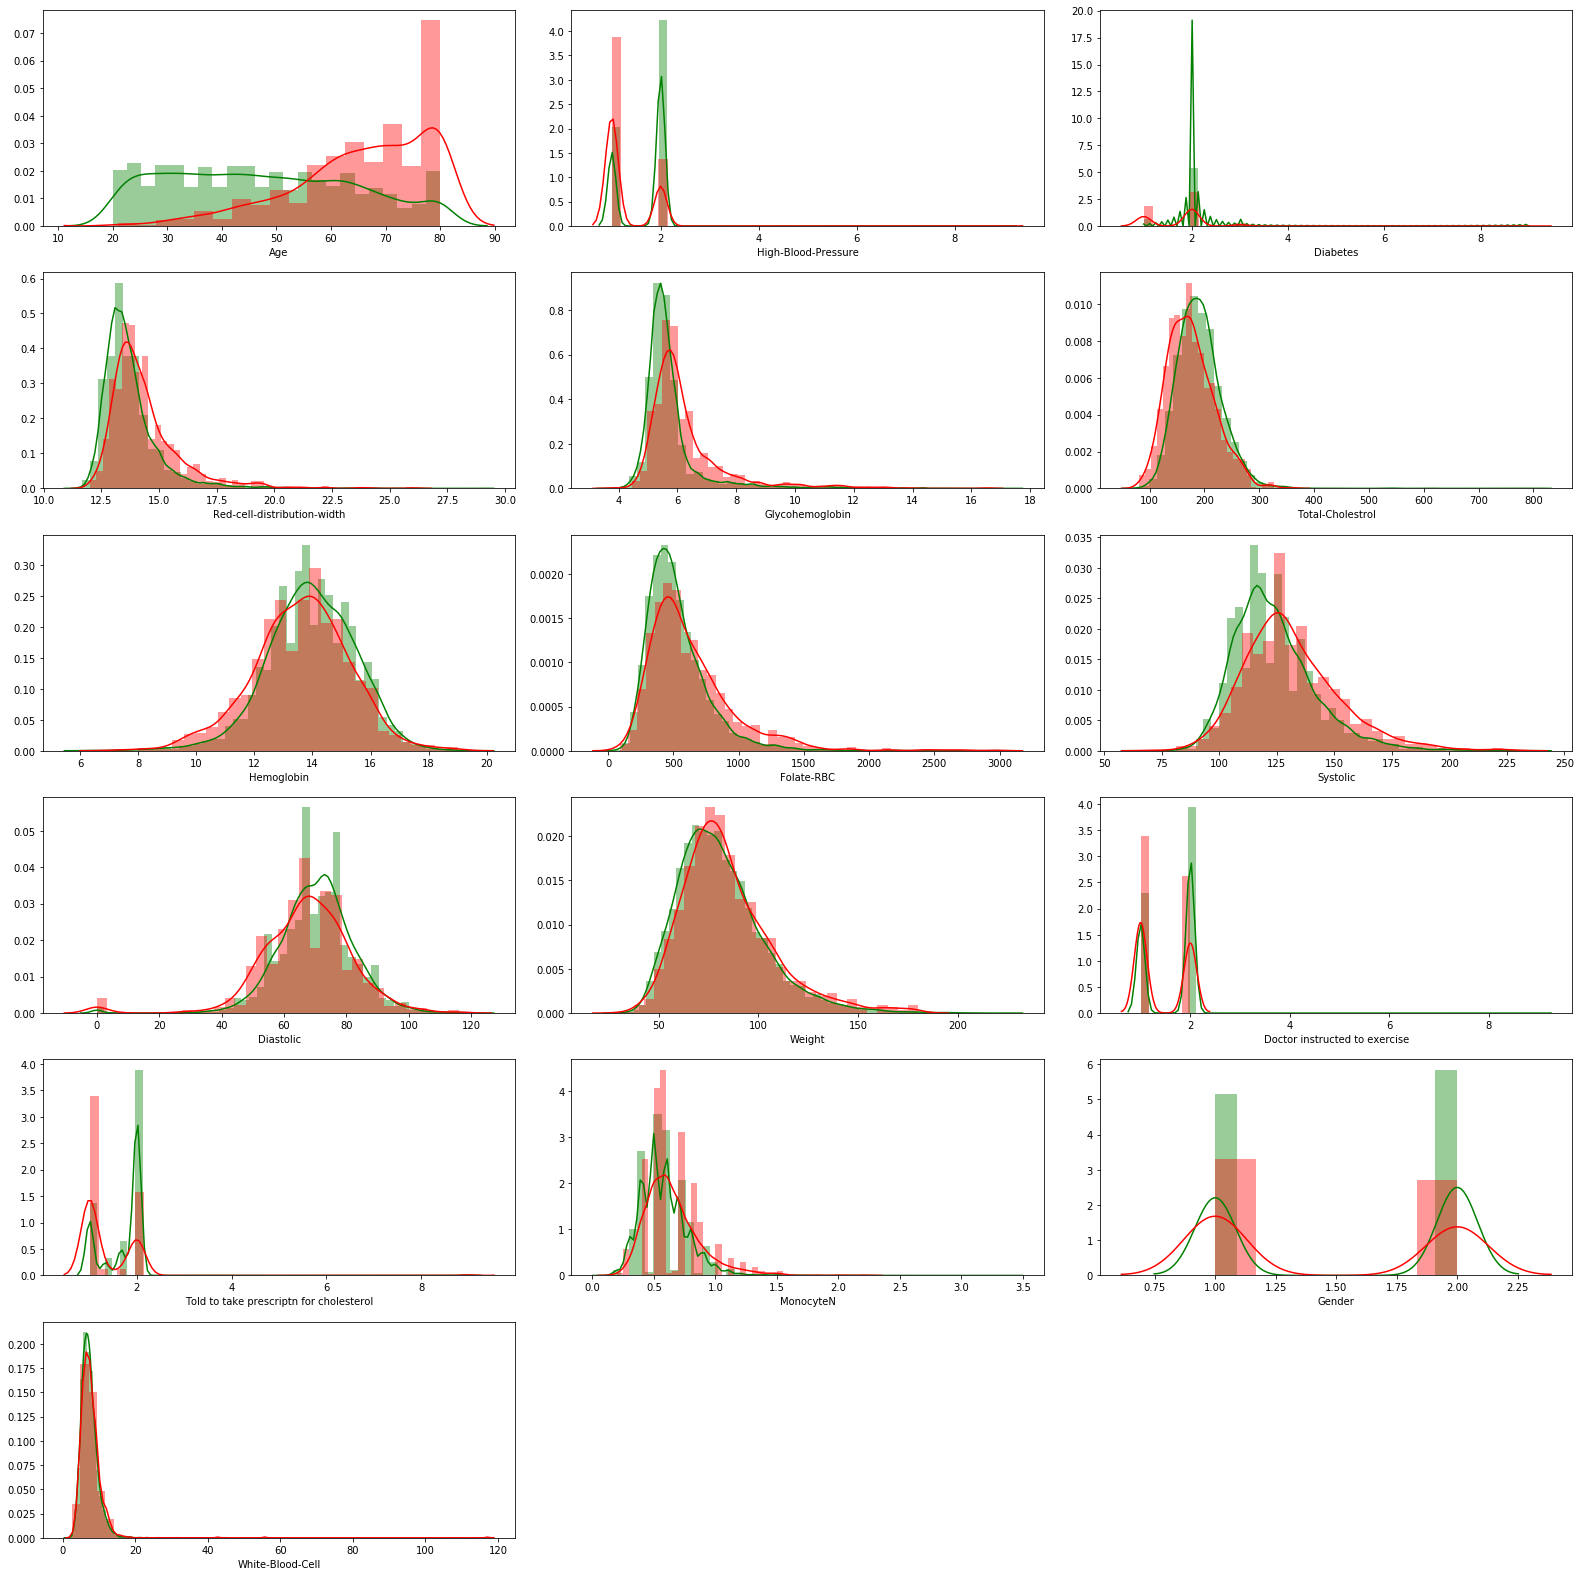

In [14]:
cor=NHANES[['Age','High-Blood-Pressure','Diabetes','Red-cell-distribution-width',
             'Glycohemoglobin','Total-Cholestrol','Hemoglobin','Folate-RBC','Systolic','Diastolic','Weight','Doctor instructed to exercise',
            'Told to take prescriptn for cholesterol','MonocyteN','Gender','White-Blood-Cell']]

f = plt.figure(figsize = (22, 22))
ind=0
for biomarker in cor:
    plt.subplot(6, 3, ind+1)
    ind = ind+1
    sns.distplot(NHANES[biomarker][NHANES['CVD']==0],color='g', label = 'Non Present')
    sns.distplot(NHANES[biomarker][NHANES['CVD']==1],color='r', label = 'CVD')
    #plt.legend(loc='best')
f.tight_layout()
plt.show()

In [15]:
pair=NHANES[['Age',
             'Glycohemoglobin','Total-Cholestrol','Hemoglobin','Folate-RBC','Weight',
             'MonocyteN','Gender','White-Blood-Cell',]]

#sns.pairplot(pair)


#### Create variables for different paramater use

In [16]:
rate01 = pd.DataFrame(NHANES)
rate001 = pd.DataFrame(NHANES)
rate0001 = pd.DataFrame(NHANES)

dataset.shape

(10979, 144)

In [17]:
n=[0,3062,2262,2262] # Dataset Ratios (8:1, 6:1, 4:1, 2:1)
# Drop out rate
drop1=0.3
drop2=0.6

Class Ratio 9848 : 1131
(8783, 142)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 8783 samples, validate on 2196 samples
Epoch 1/100
8783/8783 [==============================] - 1s 96us/step - loss: 0.3239 - accuracy: 0.8889 - val_loss: 0.2510 - val_accuracy: 0.8980
Epoch 2/100
8783/8783 [==============================] - 1s 68us/step - loss: 0.2604 - accuracy: 0.8976 - val_loss: 0.2479 - val_accuracy: 0.8971
Epoch 3/100
8783/8783 [==============================] - 1s 72us/step - loss: 0.2456 - accuracy: 0.9016 - val_loss: 0.2480 - val_accuracy: 0.8971
Epoch 4/100
8783/8783 [==============================] - 1s 70us/step - loss: 0.2403 - accuracy: 0.9004 - val_loss: 0.2469 - val_accuracy: 0.8985
Epoch 5/100
8783/8783 [==============================] - 1s 67us/step - loss: 0.2370 - accuracy: 0.9022 - val_loss: 0.2428 - val_accuracy: 0.9012
Epoch 6/100
8783/8783 [==============================] - 1s 82us/s

8783/8783 [==============================] - 1s 62us/step - loss: 0.0917 - accuracy: 0.9660 - val_loss: 0.4148 - val_accuracy: 0.8880
Epoch 53/100
8783/8783 [==============================] - 1s 62us/step - loss: 0.0878 - accuracy: 0.9694 - val_loss: 0.4063 - val_accuracy: 0.8916
Epoch 54/100
8783/8783 [==============================] - 1s 61us/step - loss: 0.0806 - accuracy: 0.9690 - val_loss: 0.4556 - val_accuracy: 0.8898
Epoch 55/100
8783/8783 [==============================] - 1s 60us/step - loss: 0.0833 - accuracy: 0.9695 - val_loss: 0.4442 - val_accuracy: 0.8880
Epoch 56/100
8783/8783 [==============================] - 1s 61us/step - loss: 0.0789 - accuracy: 0.9697 - val_loss: 0.4424 - val_accuracy: 0.8930
Epoch 57/100
8783/8783 [==============================] - 1s 57us/step - loss: 0.0720 - accuracy: 0.9734 - val_loss: 0.4774 - val_accuracy: 0.8903
Epoch 58/100
8783/8783 [==============================] - 1s 58us/step - loss: 0.0728 - accuracy: 0.9729 - val_loss: 0.4686 - val_a

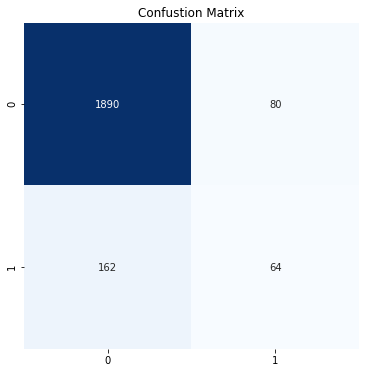

Class Ratio 6786 : 1131
(6333, 142)
Train on 6333 samples, validate on 1584 samples
Epoch 1/100
6333/6333 [==============================] - 1s 105us/step - loss: 0.3902 - accuracy: 0.8501 - val_loss: 0.3071 - val_accuracy: 0.8586
Epoch 2/100
6333/6333 [==============================] - 0s 68us/step - loss: 0.3194 - accuracy: 0.8623 - val_loss: 0.2990 - val_accuracy: 0.8687
Epoch 3/100
6333/6333 [==============================] - 0s 68us/step - loss: 0.3026 - accuracy: 0.8678 - val_loss: 0.2990 - val_accuracy: 0.8636
Epoch 4/100
6333/6333 [==============================] - 0s 73us/step - loss: 0.2867 - accuracy: 0.8759 - val_loss: 0.2934 - val_accuracy: 0.8750
Epoch 5/100
6333/6333 [==============================] - 0s 63us/step - loss: 0.2763 - accuracy: 0.8762 - val_loss: 0.2992 - val_accuracy: 0.8662
Epoch 6/100
6333/6333 [==============================] - 0s 68us/step - loss: 0.2725 - accuracy: 0.8775 - val_loss: 0.2990 - val_accuracy: 0.8649
Epoch 7/100
6333/6333 [================

6333/6333 [==============================] - 0s 63us/step - loss: 0.0962 - accuracy: 0.9651 - val_loss: 0.4718 - val_accuracy: 0.8706
Epoch 57/100
6333/6333 [==============================] - 0s 73us/step - loss: 0.0976 - accuracy: 0.9635 - val_loss: 0.4845 - val_accuracy: 0.8662
Epoch 58/100
6333/6333 [==============================] - 0s 68us/step - loss: 0.0931 - accuracy: 0.9649 - val_loss: 0.5131 - val_accuracy: 0.8624
Epoch 59/100
6333/6333 [==============================] - 0s 75us/step - loss: 0.0947 - accuracy: 0.9645 - val_loss: 0.5332 - val_accuracy: 0.8668
Epoch 60/100
6333/6333 [==============================] - 0s 75us/step - loss: 0.0918 - accuracy: 0.9664 - val_loss: 0.5373 - val_accuracy: 0.8624
Epoch 61/100
6333/6333 [==============================] - 1s 93us/step - loss: 0.0854 - accuracy: 0.9695 - val_loss: 0.5262 - val_accuracy: 0.8624
Epoch 62/100
6333/6333 [==============================] - 0s 63us/step - loss: 0.0813 - accuracy: 0.9695 - val_loss: 0.5472 - val_a

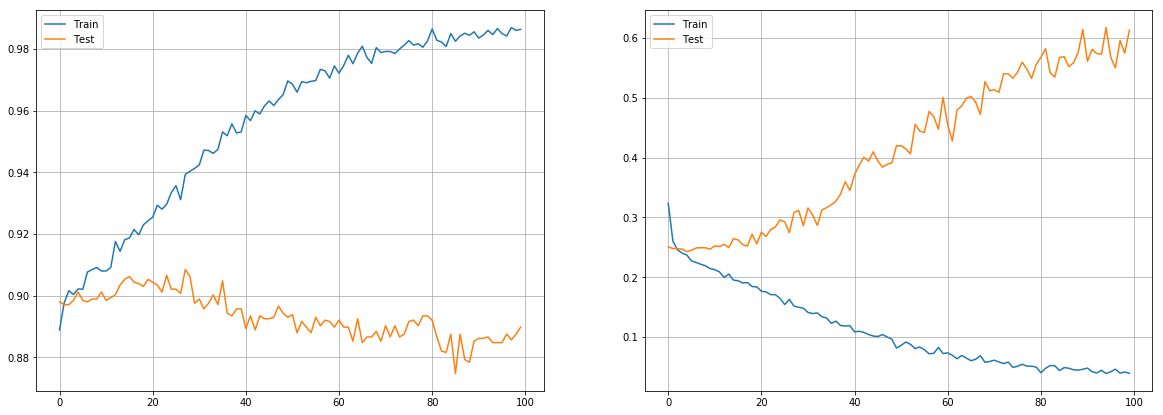

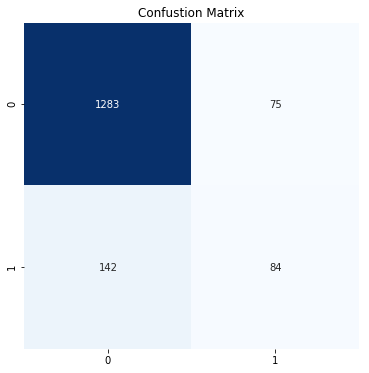

Class Ratio 4524 : 1131
(4524, 142)
Train on 4524 samples, validate on 1131 samples
Epoch 1/100
4524/4524 [==============================] - 1s 147us/step - loss: 0.4565 - accuracy: 0.8026 - val_loss: 0.3456 - val_accuracy: 0.8462
Epoch 2/100
4524/4524 [==============================] - 0s 72us/step - loss: 0.3748 - accuracy: 0.8307 - val_loss: 0.3311 - val_accuracy: 0.8559
Epoch 3/100
4524/4524 [==============================] - 0s 84us/step - loss: 0.3455 - accuracy: 0.8408 - val_loss: 0.3262 - val_accuracy: 0.8523
Epoch 4/100
4524/4524 [==============================] - 0s 66us/step - loss: 0.3276 - accuracy: 0.8528 - val_loss: 0.3227 - val_accuracy: 0.8621
Epoch 5/100
4524/4524 [==============================] - 0s 67us/step - loss: 0.3161 - accuracy: 0.8550 - val_loss: 0.3289 - val_accuracy: 0.8497
Epoch 6/100
4524/4524 [==============================] - 0s 80us/step - loss: 0.3123 - accuracy: 0.8645 - val_loss: 0.3226 - val_accuracy: 0.8656
Epoch 7/100
4524/4524 [================

4524/4524 [==============================] - 0s 71us/step - loss: 0.0959 - accuracy: 0.9637 - val_loss: 0.5650 - val_accuracy: 0.8638
Epoch 57/100
4524/4524 [==============================] - 0s 82us/step - loss: 0.0893 - accuracy: 0.9660 - val_loss: 0.5703 - val_accuracy: 0.8621
Epoch 58/100
4524/4524 [==============================] - 0s 104us/step - loss: 0.0758 - accuracy: 0.9715 - val_loss: 0.6134 - val_accuracy: 0.8585
Epoch 59/100
4524/4524 [==============================] - 0s 70us/step - loss: 0.0902 - accuracy: 0.9668 - val_loss: 0.5777 - val_accuracy: 0.8523
Epoch 60/100
4524/4524 [==============================] - 0s 64us/step - loss: 0.0769 - accuracy: 0.9721 - val_loss: 0.6141 - val_accuracy: 0.8550
Epoch 61/100
4524/4524 [==============================] - 0s 79us/step - loss: 0.0884 - accuracy: 0.9695 - val_loss: 0.5706 - val_accuracy: 0.8576
Epoch 62/100
4524/4524 [==============================] - 0s 93us/step - loss: 0.0841 - accuracy: 0.9708 - val_loss: 0.5824 - val_

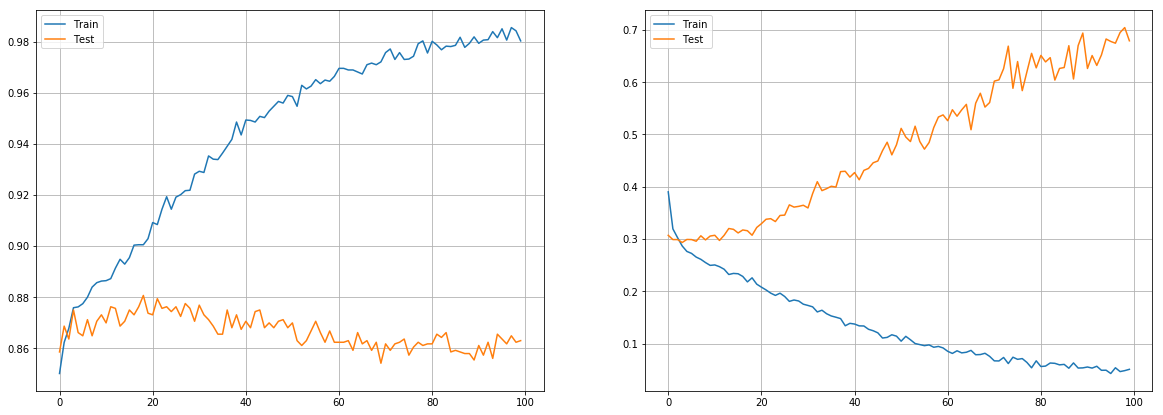

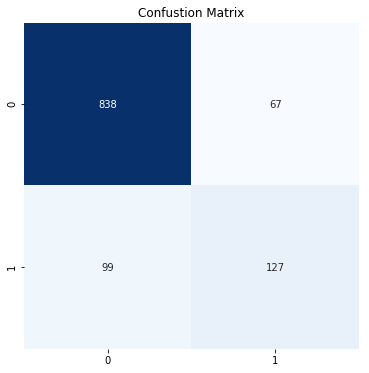

Class Ratio 2262 : 1131
(2714, 142)
Train on 2714 samples, validate on 679 samples
Epoch 1/100
2714/2714 [==============================] - 0s 172us/step - loss: 0.5982 - accuracy: 0.6931 - val_loss: 0.4203 - val_accuracy: 0.7982
Epoch 2/100
2714/2714 [==============================] - 0s 69us/step - loss: 0.5004 - accuracy: 0.7572 - val_loss: 0.3921 - val_accuracy: 0.8277
Epoch 3/100
2714/2714 [==============================] - 0s 64us/step - loss: 0.4501 - accuracy: 0.7903 - val_loss: 0.3685 - val_accuracy: 0.8454
Epoch 4/100
2714/2714 [==============================] - 0s 70us/step - loss: 0.4249 - accuracy: 0.7999 - val_loss: 0.3669 - val_accuracy: 0.8351
Epoch 5/100
2714/2714 [==============================] - 0s 72us/step - loss: 0.3980 - accuracy: 0.8202 - val_loss: 0.3712 - val_accuracy: 0.8527
Epoch 6/100
2714/2714 [==============================] - 0s 67us/step - loss: 0.3925 - accuracy: 0.8191 - val_loss: 0.3506 - val_accuracy: 0.8542
Epoch 7/100
2714/2714 [=================

2714/2714 [==============================] - 0s 95us/step - loss: 0.1114 - accuracy: 0.9550 - val_loss: 0.6445 - val_accuracy: 0.8321
Epoch 57/100
2714/2714 [==============================] - 0s 66us/step - loss: 0.1022 - accuracy: 0.9617 - val_loss: 0.6216 - val_accuracy: 0.8203
Epoch 58/100
2714/2714 [==============================] - 0s 94us/step - loss: 0.0996 - accuracy: 0.9639 - val_loss: 0.6630 - val_accuracy: 0.8130
Epoch 59/100
2714/2714 [==============================] - 0s 116us/step - loss: 0.0954 - accuracy: 0.9624 - val_loss: 0.6772 - val_accuracy: 0.8144
Epoch 60/100
2714/2714 [==============================] - 0s 98us/step - loss: 0.0923 - accuracy: 0.9657 - val_loss: 0.7094 - val_accuracy: 0.8159
Epoch 61/100
2714/2714 [==============================] - 0s 77us/step - loss: 0.0965 - accuracy: 0.9679 - val_loss: 0.6940 - val_accuracy: 0.8144
Epoch 62/100
2714/2714 [==============================] - 0s 73us/step - loss: 0.0933 - accuracy: 0.9665 - val_loss: 0.6883 - val_

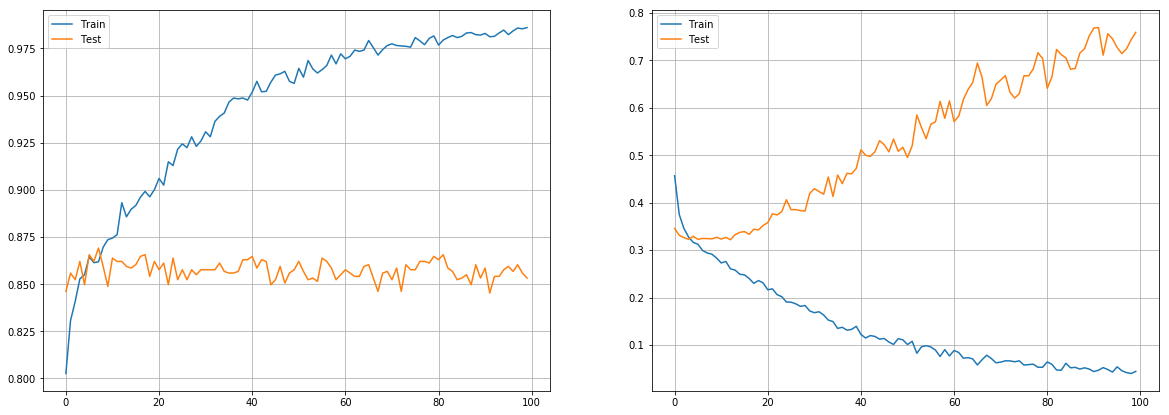

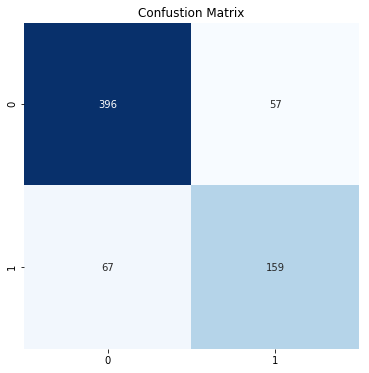

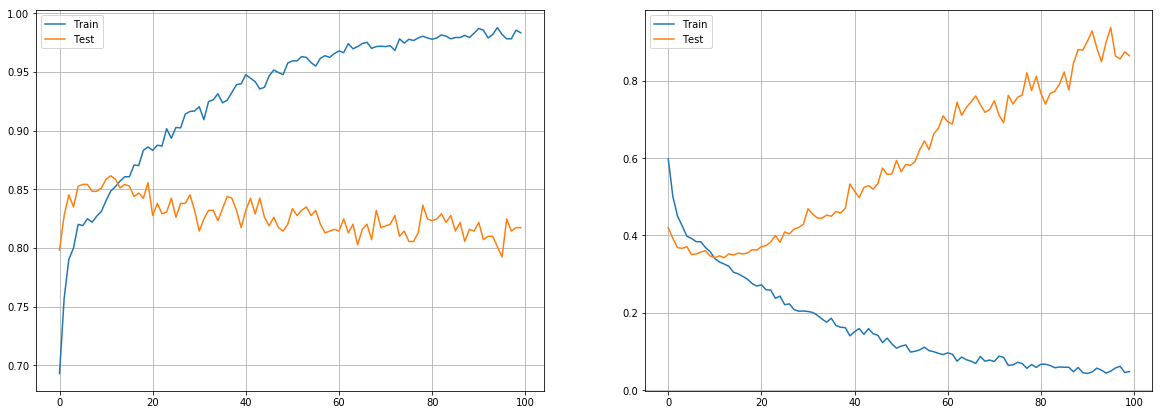

In [18]:
lrate=0.1
setLrate(rate01,lrate,drop1,drop2)


In [19]:
#NHANES.to_csv('preprocessed.csv')

#### Learning Rate 0.01

Class Ratio 9848 : 1131
(8783, 142)
Train on 8783 samples, validate on 2196 samples
Epoch 1/100
8783/8783 [==============================] - 1s 114us/step - loss: 0.4134 - accuracy: 0.8803 - val_loss: 0.3377 - val_accuracy: 0.8971
Epoch 2/100
8783/8783 [==============================] - 1s 76us/step - loss: 0.3470 - accuracy: 0.8957 - val_loss: 0.2982 - val_accuracy: 0.8975
Epoch 3/100
8783/8783 [==============================] - 1s 80us/step - loss: 0.3232 - accuracy: 0.8973 - val_loss: 0.2813 - val_accuracy: 0.8994
Epoch 4/100
8783/8783 [==============================] - 1s 65us/step - loss: 0.3061 - accuracy: 0.8964 - val_loss: 0.2689 - val_accuracy: 0.9007
Epoch 5/100
8783/8783 [==============================] - 1s 70us/step - loss: 0.2973 - accuracy: 0.8941 - val_loss: 0.2644 - val_accuracy: 0.8989
Epoch 6/100
8783/8783 [==============================] - 1s 64us/step - loss: 0.2834 - accuracy: 0.8958 - val_loss: 0.2595 - val_accuracy: 0.8989
Epoch 7/100
8783/8783 [================

8783/8783 [==============================] - 1s 156us/step - loss: 0.2137 - accuracy: 0.9082 - val_loss: 0.2435 - val_accuracy: 0.9035
Epoch 57/100
8783/8783 [==============================] - 1s 135us/step - loss: 0.2155 - accuracy: 0.9078 - val_loss: 0.2437 - val_accuracy: 0.9026
Epoch 58/100
8783/8783 [==============================] - 1s 152us/step - loss: 0.2149 - accuracy: 0.9113 - val_loss: 0.2433 - val_accuracy: 0.9030
Epoch 59/100
8783/8783 [==============================] - 1s 153us/step - loss: 0.2150 - accuracy: 0.9110 - val_loss: 0.2442 - val_accuracy: 0.9026
Epoch 60/100
8783/8783 [==============================] - 1s 132us/step - loss: 0.2164 - accuracy: 0.9079 - val_loss: 0.2432 - val_accuracy: 0.9026
Epoch 61/100
8783/8783 [==============================] - 1s 112us/step - loss: 0.2128 - accuracy: 0.9091 - val_loss: 0.2435 - val_accuracy: 0.9026
Epoch 62/100
8783/8783 [==============================] - 1s 141us/step - loss: 0.2139 - accuracy: 0.9078 - val_loss: 0.2430 

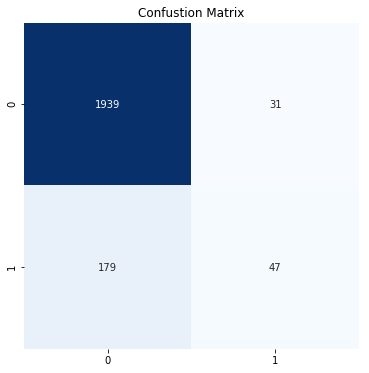

Class Ratio 6786 : 1131
(6333, 142)
Train on 6333 samples, validate on 1584 samples
Epoch 1/100
6333/6333 [==============================] - 1s 164us/step - loss: 0.5302 - accuracy: 0.7927 - val_loss: 0.4129 - val_accuracy: 0.8573
Epoch 2/100
6333/6333 [==============================] - 1s 95us/step - loss: 0.4350 - accuracy: 0.8538 - val_loss: 0.3727 - val_accuracy: 0.8573
Epoch 3/100
6333/6333 [==============================] - 1s 84us/step - loss: 0.4066 - accuracy: 0.8539 - val_loss: 0.3486 - val_accuracy: 0.8580
Epoch 4/100
6333/6333 [==============================] - 1s 98us/step - loss: 0.3729 - accuracy: 0.8618 - val_loss: 0.3289 - val_accuracy: 0.8592
Epoch 5/100
6333/6333 [==============================] - 1s 108us/step - loss: 0.3578 - accuracy: 0.8606 - val_loss: 0.3174 - val_accuracy: 0.8617
Epoch 6/100
6333/6333 [==============================] - 1s 93us/step - loss: 0.3478 - accuracy: 0.8639 - val_loss: 0.3104 - val_accuracy: 0.8681
Epoch 7/100
6333/6333 [===============

6333/6333 [==============================] - 0s 78us/step - loss: 0.2608 - accuracy: 0.8844 - val_loss: 0.2831 - val_accuracy: 0.8807
Epoch 57/100
6333/6333 [==============================] - 1s 96us/step - loss: 0.2605 - accuracy: 0.8841 - val_loss: 0.2827 - val_accuracy: 0.8807
Epoch 58/100
6333/6333 [==============================] - 1s 110us/step - loss: 0.2558 - accuracy: 0.8828 - val_loss: 0.2836 - val_accuracy: 0.8794
Epoch 59/100
6333/6333 [==============================] - 1s 100us/step - loss: 0.2610 - accuracy: 0.8814 - val_loss: 0.2836 - val_accuracy: 0.8807
Epoch 60/100
6333/6333 [==============================] - 1s 108us/step - loss: 0.2605 - accuracy: 0.8832 - val_loss: 0.2843 - val_accuracy: 0.8819
Epoch 61/100
6333/6333 [==============================] - 1s 150us/step - loss: 0.2575 - accuracy: 0.8817 - val_loss: 0.2845 - val_accuracy: 0.8826
Epoch 62/100
6333/6333 [==============================] - 0s 74us/step - loss: 0.2577 - accuracy: 0.8865 - val_loss: 0.2847 - v

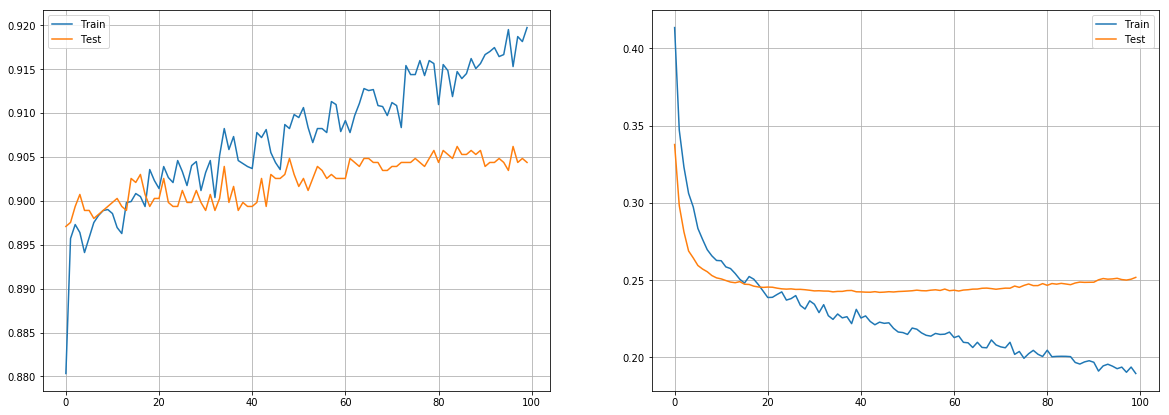

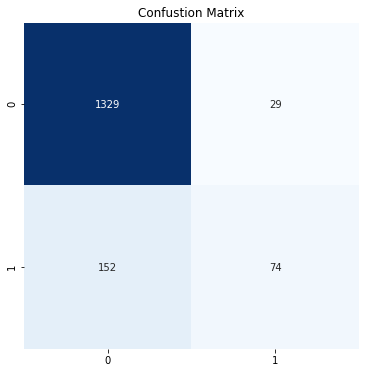

Class Ratio 4524 : 1131
(4524, 142)
Train on 4524 samples, validate on 1131 samples
Epoch 1/100
4524/4524 [==============================] - 1s 144us/step - loss: 0.6195 - accuracy: 0.7140 - val_loss: 0.5035 - val_accuracy: 0.8002
Epoch 2/100
4524/4524 [==============================] - 0s 71us/step - loss: 0.5318 - accuracy: 0.7900 - val_loss: 0.4603 - val_accuracy: 0.8019
Epoch 3/100
4524/4524 [==============================] - 0s 76us/step - loss: 0.4852 - accuracy: 0.8037 - val_loss: 0.4238 - val_accuracy: 0.8055
Epoch 4/100
4524/4524 [==============================] - 0s 67us/step - loss: 0.4629 - accuracy: 0.8015 - val_loss: 0.3998 - val_accuracy: 0.8161
Epoch 5/100
4524/4524 [==============================] - 0s 68us/step - loss: 0.4323 - accuracy: 0.8165 - val_loss: 0.3790 - val_accuracy: 0.8240
Epoch 6/100
4524/4524 [==============================] - 0s 72us/step - loss: 0.4302 - accuracy: 0.8137 - val_loss: 0.3689 - val_accuracy: 0.8329
Epoch 7/100
4524/4524 [================

4524/4524 [==============================] - 0s 110us/step - loss: 0.2900 - accuracy: 0.8714 - val_loss: 0.3132 - val_accuracy: 0.8559
Epoch 57/100
4524/4524 [==============================] - 0s 109us/step - loss: 0.2891 - accuracy: 0.8652 - val_loss: 0.3127 - val_accuracy: 0.8559
Epoch 58/100
4524/4524 [==============================] - 0s 70us/step - loss: 0.2860 - accuracy: 0.8678 - val_loss: 0.3134 - val_accuracy: 0.8559
Epoch 59/100
4524/4524 [==============================] - 0s 69us/step - loss: 0.2855 - accuracy: 0.8720 - val_loss: 0.3124 - val_accuracy: 0.8594
Epoch 60/100
4524/4524 [==============================] - 1s 115us/step - loss: 0.2852 - accuracy: 0.8674 - val_loss: 0.3146 - val_accuracy: 0.8532
Epoch 61/100
4524/4524 [==============================] - 0s 97us/step - loss: 0.2877 - accuracy: 0.8733 - val_loss: 0.3146 - val_accuracy: 0.8559
Epoch 62/100
4524/4524 [==============================] - 0s 76us/step - loss: 0.2888 - accuracy: 0.8700 - val_loss: 0.3151 - va

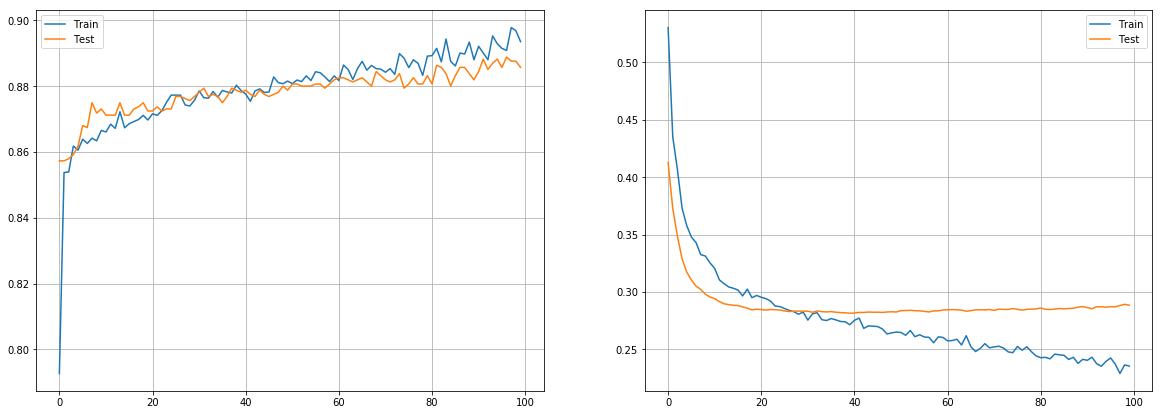

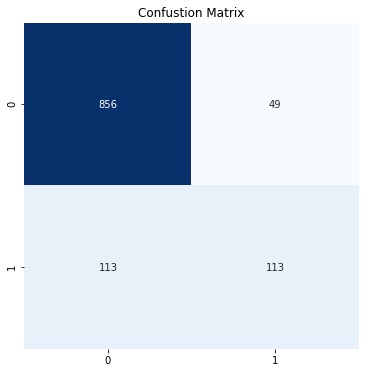

Class Ratio 2262 : 1131
(2714, 142)
Train on 2714 samples, validate on 679 samples
Epoch 1/100
2714/2714 [==============================] - 1s 218us/step - loss: 0.6843 - accuracy: 0.6389 - val_loss: 0.6255 - val_accuracy: 0.7128
Epoch 2/100
2714/2714 [==============================] - 0s 72us/step - loss: 0.6468 - accuracy: 0.6813 - val_loss: 0.5983 - val_accuracy: 0.7452
Epoch 3/100
2714/2714 [==============================] - 0s 83us/step - loss: 0.6141 - accuracy: 0.6887 - val_loss: 0.5706 - val_accuracy: 0.7482
Epoch 4/100
2714/2714 [==============================] - 0s 84us/step - loss: 0.5971 - accuracy: 0.7049 - val_loss: 0.5473 - val_accuracy: 0.7599
Epoch 5/100
2714/2714 [==============================] - 0s 70us/step - loss: 0.5624 - accuracy: 0.7248 - val_loss: 0.5242 - val_accuracy: 0.7732
Epoch 6/100
2714/2714 [==============================] - 0s 74us/step - loss: 0.5557 - accuracy: 0.7343 - val_loss: 0.5097 - val_accuracy: 0.7835
Epoch 7/100
2714/2714 [=================

2714/2714 [==============================] - 0s 100us/step - loss: 0.3750 - accuracy: 0.8276 - val_loss: 0.3931 - val_accuracy: 0.8218
Epoch 57/100
2714/2714 [==============================] - 0s 114us/step - loss: 0.3595 - accuracy: 0.8382 - val_loss: 0.3940 - val_accuracy: 0.8203
Epoch 58/100
2714/2714 [==============================] - 0s 124us/step - loss: 0.3538 - accuracy: 0.8386 - val_loss: 0.3942 - val_accuracy: 0.8189
Epoch 59/100
2714/2714 [==============================] - 0s 132us/step - loss: 0.3706 - accuracy: 0.8379 - val_loss: 0.3942 - val_accuracy: 0.8189
Epoch 60/100
2714/2714 [==============================] - 0s 74us/step - loss: 0.3445 - accuracy: 0.8489 - val_loss: 0.3956 - val_accuracy: 0.8189
Epoch 61/100
2714/2714 [==============================] - 0s 81us/step - loss: 0.3517 - accuracy: 0.8449 - val_loss: 0.3954 - val_accuracy: 0.8203
Epoch 62/100
2714/2714 [==============================] - 0s 76us/step - loss: 0.3451 - accuracy: 0.8471 - val_loss: 0.3956 - v

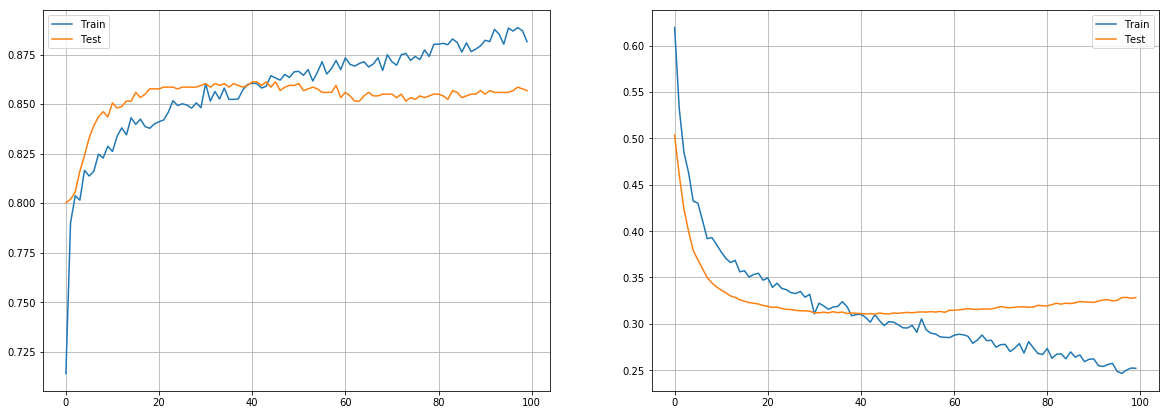

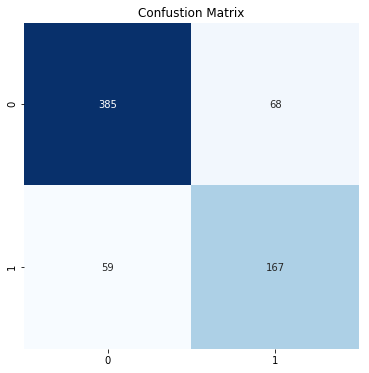

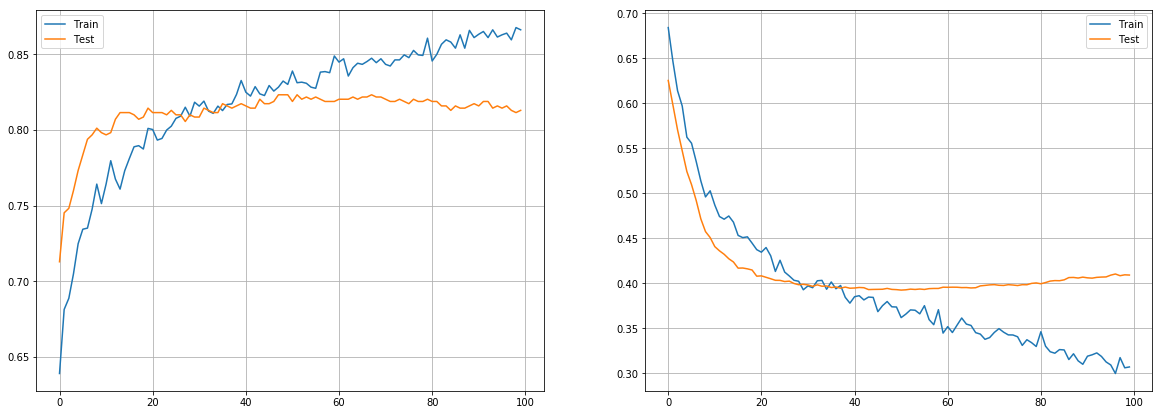

In [20]:
lrate=0.01
setLrate(rate001,lrate,drop1,drop2)

#### ### Learning Rate 0.001

Class Ratio 9848 : 1131
(8783, 142)
Train on 8783 samples, validate on 2196 samples
Epoch 1/100
8783/8783 [==============================] - 1s 142us/step - loss: 0.5959 - accuracy: 0.7115 - val_loss: 0.4381 - val_accuracy: 0.8962
Epoch 2/100
8783/8783 [==============================] - 1s 67us/step - loss: 0.4543 - accuracy: 0.8644 - val_loss: 0.3945 - val_accuracy: 0.8971
Epoch 3/100
8783/8783 [==============================] - 1s 70us/step - loss: 0.4307 - accuracy: 0.8867 - val_loss: 0.3788 - val_accuracy: 0.8971
Epoch 4/100
8783/8783 [==============================] - 1s 70us/step - loss: 0.4265 - accuracy: 0.8880 - val_loss: 0.3696 - val_accuracy: 0.8971
Epoch 5/100
8783/8783 [==============================] - 1s 70us/step - loss: 0.4061 - accuracy: 0.8922 - val_loss: 0.3626 - val_accuracy: 0.8971
Epoch 6/100
8783/8783 [==============================] - 1s 69us/step - loss: 0.4046 - accuracy: 0.8918 - val_loss: 0.3561 - val_accuracy: 0.8971
Epoch 7/100
8783/8783 [================

8783/8783 [==============================] - 1s 83us/step - loss: 0.2819 - accuracy: 0.8994 - val_loss: 0.2628 - val_accuracy: 0.8975
Epoch 57/100
8783/8783 [==============================] - 1s 83us/step - loss: 0.2835 - accuracy: 0.8981 - val_loss: 0.2628 - val_accuracy: 0.8985
Epoch 58/100
8783/8783 [==============================] - 1s 69us/step - loss: 0.2869 - accuracy: 0.8964 - val_loss: 0.2626 - val_accuracy: 0.8985
Epoch 59/100
8783/8783 [==============================] - 1s 72us/step - loss: 0.2851 - accuracy: 0.8974 - val_loss: 0.2624 - val_accuracy: 0.8989
Epoch 60/100
8783/8783 [==============================] - 1s 83us/step - loss: 0.2796 - accuracy: 0.8971 - val_loss: 0.2619 - val_accuracy: 0.8989
Epoch 61/100
8783/8783 [==============================] - 1s 95us/step - loss: 0.2777 - accuracy: 0.8966 - val_loss: 0.2615 - val_accuracy: 0.8985
Epoch 62/100
8783/8783 [==============================] - 1s 74us/step - loss: 0.2804 - accuracy: 0.8971 - val_loss: 0.2611 - val_a

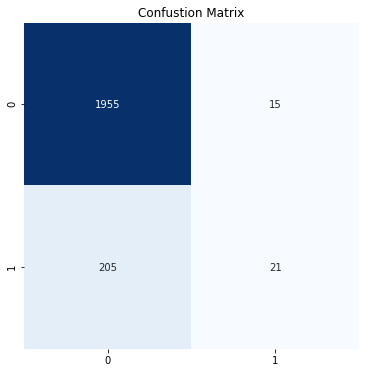

Class Ratio 6786 : 1131
(6333, 142)
Train on 6333 samples, validate on 1584 samples
Epoch 1/100
6333/6333 [==============================] - 3s 478us/step - loss: 0.8833 - accuracy: 0.4912 - val_loss: 0.5291 - val_accuracy: 0.8409
Epoch 2/100
6333/6333 [==============================] - 1s 177us/step - loss: 0.5642 - accuracy: 0.7679 - val_loss: 0.4663 - val_accuracy: 0.8573
Epoch 3/100
6333/6333 [==============================] - 1s 103us/step - loss: 0.5101 - accuracy: 0.8189 - val_loss: 0.4497 - val_accuracy: 0.8573
Epoch 4/100
6333/6333 [==============================] - 1s 94us/step - loss: 0.5064 - accuracy: 0.8304 - val_loss: 0.4401 - val_accuracy: 0.8573
Epoch 5/100
6333/6333 [==============================] - 1s 138us/step - loss: 0.4968 - accuracy: 0.8361 - val_loss: 0.4320 - val_accuracy: 0.8573
Epoch 6/100
6333/6333 [==============================] - 1s 165us/step - loss: 0.4831 - accuracy: 0.8429 - val_loss: 0.4256 - val_accuracy: 0.8573
Epoch 7/100
6333/6333 [============

6333/6333 [==============================] - 0s 79us/step - loss: 0.3513 - accuracy: 0.8598 - val_loss: 0.3201 - val_accuracy: 0.8592
Epoch 57/100
6333/6333 [==============================] - 1s 103us/step - loss: 0.3503 - accuracy: 0.8606 - val_loss: 0.3195 - val_accuracy: 0.8592
Epoch 58/100
6333/6333 [==============================] - 1s 80us/step - loss: 0.3496 - accuracy: 0.8587 - val_loss: 0.3189 - val_accuracy: 0.8592
Epoch 59/100
6333/6333 [==============================] - 1s 101us/step - loss: 0.3442 - accuracy: 0.8610 - val_loss: 0.3182 - val_accuracy: 0.8592
Epoch 60/100
6333/6333 [==============================] - 1s 82us/step - loss: 0.3466 - accuracy: 0.8604 - val_loss: 0.3177 - val_accuracy: 0.8592
Epoch 61/100
6333/6333 [==============================] - 1s 116us/step - loss: 0.3474 - accuracy: 0.8582 - val_loss: 0.3172 - val_accuracy: 0.8592
Epoch 62/100
6333/6333 [==============================] - 0s 76us/step - loss: 0.3385 - accuracy: 0.8595 - val_loss: 0.3166 - va

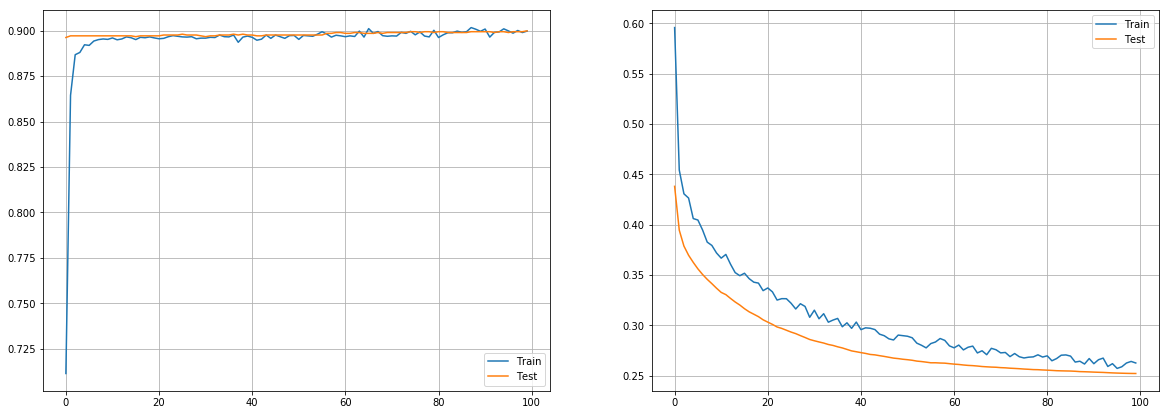

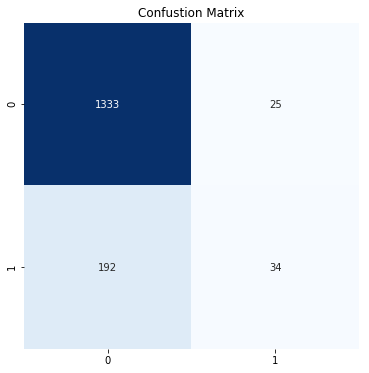

Class Ratio 4524 : 1131
(4524, 142)
Train on 4524 samples, validate on 1131 samples
Epoch 1/100
4524/4524 [==============================] - 1s 171us/step - loss: 0.6879 - accuracy: 0.6320 - val_loss: 0.6486 - val_accuracy: 0.6958
Epoch 2/100
4524/4524 [==============================] - 0s 69us/step - loss: 0.6373 - accuracy: 0.7104 - val_loss: 0.6150 - val_accuracy: 0.7622
Epoch 3/100
4524/4524 [==============================] - 0s 75us/step - loss: 0.6277 - accuracy: 0.7385 - val_loss: 0.5960 - val_accuracy: 0.7860
Epoch 4/100
4524/4524 [==============================] - 0s 74us/step - loss: 0.5978 - accuracy: 0.7613 - val_loss: 0.5824 - val_accuracy: 0.7975
Epoch 5/100
4524/4524 [==============================] - 0s 69us/step - loss: 0.5858 - accuracy: 0.7699 - val_loss: 0.5714 - val_accuracy: 0.7984
Epoch 6/100
4524/4524 [==============================] - 0s 68us/step - loss: 0.5843 - accuracy: 0.7807 - val_loss: 0.5628 - val_accuracy: 0.7975
Epoch 7/100
4524/4524 [================

4524/4524 [==============================] - 0s 72us/step - loss: 0.4433 - accuracy: 0.8090 - val_loss: 0.4227 - val_accuracy: 0.8276
Epoch 57/100
4524/4524 [==============================] - 0s 73us/step - loss: 0.4472 - accuracy: 0.8084 - val_loss: 0.4208 - val_accuracy: 0.8267
Epoch 58/100
4524/4524 [==============================] - 0s 77us/step - loss: 0.4523 - accuracy: 0.8059 - val_loss: 0.4187 - val_accuracy: 0.8267
Epoch 59/100
4524/4524 [==============================] - 0s 68us/step - loss: 0.4359 - accuracy: 0.8079 - val_loss: 0.4165 - val_accuracy: 0.8249
Epoch 60/100
4524/4524 [==============================] - 0s 90us/step - loss: 0.4465 - accuracy: 0.8092 - val_loss: 0.4146 - val_accuracy: 0.8258
Epoch 61/100
4524/4524 [==============================] - 0s 76us/step - loss: 0.4360 - accuracy: 0.8115 - val_loss: 0.4127 - val_accuracy: 0.8223
Epoch 62/100
4524/4524 [==============================] - 1s 115us/step - loss: 0.4377 - accuracy: 0.8081 - val_loss: 0.4107 - val_

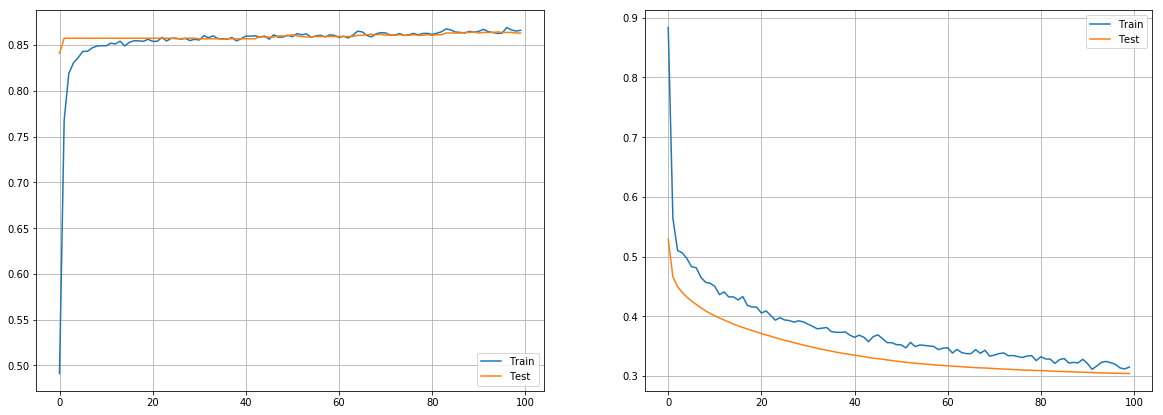

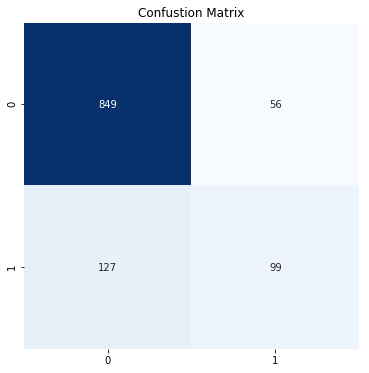

Class Ratio 2262 : 1131
(2714, 142)
Train on 2714 samples, validate on 679 samples
Epoch 1/100
2714/2714 [==============================] - 1s 225us/step - loss: 0.8420 - accuracy: 0.4466 - val_loss: 0.6873 - val_accuracy: 0.5655
Epoch 2/100
2714/2714 [==============================] - 0s 67us/step - loss: 0.7770 - accuracy: 0.5052 - val_loss: 0.6594 - val_accuracy: 0.6377
Epoch 3/100
2714/2714 [==============================] - 0s 67us/step - loss: 0.7386 - accuracy: 0.5497 - val_loss: 0.6461 - val_accuracy: 0.6613
Epoch 4/100
2714/2714 [==============================] - 0s 67us/step - loss: 0.7249 - accuracy: 0.5582 - val_loss: 0.6378 - val_accuracy: 0.6848
Epoch 5/100
2714/2714 [==============================] - 0s 67us/step - loss: 0.7092 - accuracy: 0.5840 - val_loss: 0.6315 - val_accuracy: 0.6951
Epoch 6/100
2714/2714 [==============================] - 0s 67us/step - loss: 0.7198 - accuracy: 0.5859 - val_loss: 0.6263 - val_accuracy: 0.6878
Epoch 7/100
2714/2714 [=================

2714/2714 [==============================] - 0s 158us/step - loss: 0.5311 - accuracy: 0.7310 - val_loss: 0.4951 - val_accuracy: 0.7717
Epoch 57/100
2714/2714 [==============================] - 0s 135us/step - loss: 0.5272 - accuracy: 0.7410 - val_loss: 0.4934 - val_accuracy: 0.7732
Epoch 58/100
2714/2714 [==============================] - 0s 101us/step - loss: 0.5291 - accuracy: 0.7443 - val_loss: 0.4919 - val_accuracy: 0.7747
Epoch 59/100
2714/2714 [==============================] - 0s 75us/step - loss: 0.5299 - accuracy: 0.7351 - val_loss: 0.4903 - val_accuracy: 0.7761
Epoch 60/100
2714/2714 [==============================] - 0s 75us/step - loss: 0.5308 - accuracy: 0.7439 - val_loss: 0.4887 - val_accuracy: 0.7747
Epoch 61/100
2714/2714 [==============================] - 0s 86us/step - loss: 0.5262 - accuracy: 0.7439 - val_loss: 0.4874 - val_accuracy: 0.7747
Epoch 62/100
2714/2714 [==============================] - 0s 80us/step - loss: 0.5235 - accuracy: 0.7436 - val_loss: 0.4860 - va

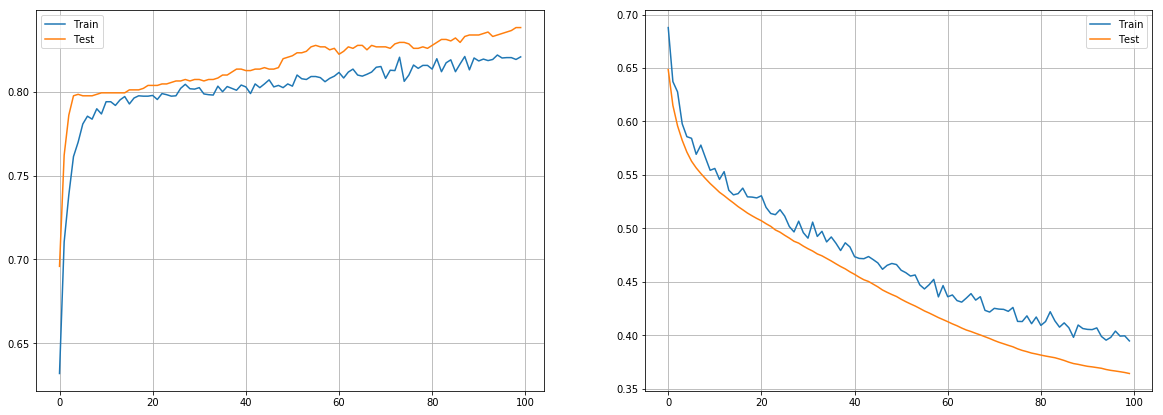

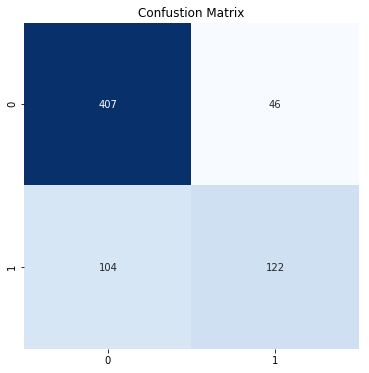

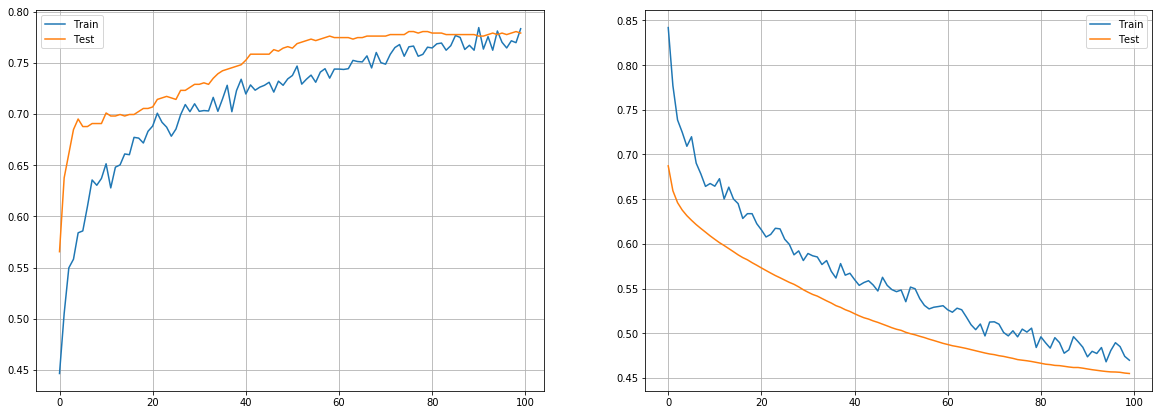

In [21]:
lrate=0.001
setLrate(rate0001,lrate,drop1,drop2)